In [63]:
#INTRINIO LIBRARIES
from __future__ import print_function
import time
import intrinio_sdk
from intrinio_sdk.rest import ApiException
from pprint import pprint

#LIBRARIES
import pandas as pd
import numpy as np
import quandl
from dotenv import load_dotenv
import os
import json
from pandas.io.json import json_normalize

#ML LIBRARIES
from sklearn import preprocessing, svm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

#PLOTING LIBRARIES
import seaborn as sns
import matplotlib.pyplot as plt

In [94]:
# GETS THE API KEY FROM .ENV FILE
def get_key(d_key):
    load_dotenv('.env')
    key = os.environ.get(d_key)
    return key

# GETS DATA FROM QUANDL / DEFAULT IS BOING DATA 
def quandl_get(code="EOD/BA", start_date="1970-01-01", end_date="2019-05-27"):
    return quandl.get(code, start_date=start_date, end_date=end_date)

# KEEP SIGNIFICANT COLUMNS. ADD CHANGE AND VOLATILITY
def feature_eng(df, n=10):
    
    df['Volatility'] = (df['Adj_High'] - df['Adj_Low']) / df['Adj_Low']
    df['Change'] = (df['Adj_Close'] - df['Adj_Open']) / df['Adj_Open']
    df=df[['Adj_Close', 'Volatility', 'Change', 'Adj_Volume']]
    
    #Defines forecast to predict
    forecast_column = 'Adj_Close'
    df.fillna('-999999', inplace=True) # N/A value treated as outlier
    forecast_out = n # number of days of prediction
    
    #shifts label
    df['future_price{}d'.format(n)] = df[forecast_column].shift(-forecast_out)
    df.dropna(inplace=True)
    return df

# INTRINO REQUESTS
def intrinio_get(key):
    
    intrinio_sdk.ApiClient().configuration.api_key['api_key'] = key

    company_api = intrinio_sdk.CompanyApi()

    identifier = 'AAPL' # str | A Company identifier (Ticker, CIK, LEI, Intrinio ID)
    tag = 'marketcap' # str | An Intrinio data tag ID or code (<a href='https://data.intrinio.com/data-tags'>reference</a>)
    frequency = 'daily' # str | Return historical data in the given frequency (optional) (default to daily)
    type = '' # str | Filter by type, when applicable (optional)
    start_date = '2018-01-01' # date | Get historical data on or after this date (optional)
    end_date = '' # date | Get historical data on or before this date (optional)
    sort_order = 'desc' # str | Sort by date `asc` or `desc` (optional) (default to desc)
    page_size = 100 # int | The number of results to return (optional) (default to 100)
    next_page = '' # str | Gets the next page of data from a previous API call (optional)

    try:
        api_response = company_api.get_company_historical_data(identifier, tag, frequency=frequency, type=type, start_date=start_date, end_date=end_date, sort_order=sort_order, page_size=page_size, next_page=next_page)
        return pd.DataFrame(api_response)
    except ApiException as e:
        print("Exception when calling CompanyApi->get_company_historical_data: %s\n" % e)

    # Note: For a Pandas DataFrame, import Pandas and use pd.DataFrame(api_response.property_name_dict)
    
    
#PLOTS CORRELATION HEATMAP AND SAVES
def plot_corr(df,size=10):
    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax = sns.heatmap(corr, annot=True, cmap="Blues").set_title("Data Correlation Heatmap")
    #fig.savefig('images/corr_heatmap.png')


Open      High       Low   Close     Volume  Dividend  Split  \
Date                                                                         
2013-09-03  105.13  105.8300  104.6600  105.01  3659800.0       0.0    1.0   
2013-09-04  105.05  107.1200  104.6200  106.37  3837500.0       0.0    1.0   
2013-09-05  106.16  106.9770  105.6702  106.65  2590500.0       0.0    1.0   
2013-09-06  107.00  107.3799  105.1100  106.07  3265200.0       0.0    1.0   
2013-09-09  106.58  107.3800  106.5550  107.19  2907600.0       0.0    1.0   

             Adj_Open   Adj_High    Adj_Low  Adj_Close  Adj_Volume  
Date                                                                
2013-09-03  91.075151  91.681568  90.667986  90.971194   3659800.0  
2013-09-04  91.005847  92.799108  90.633333  92.149376   3837500.0  
2013-09-05  91.967450  92.675226  91.543132  92.391942   2590500.0  
2013-09-06  92.695151  93.024262  91.057825  91.889483   3265200.0  
2013-09-09  92.331301  93.024348  92.309643  92.859750   2907600.0

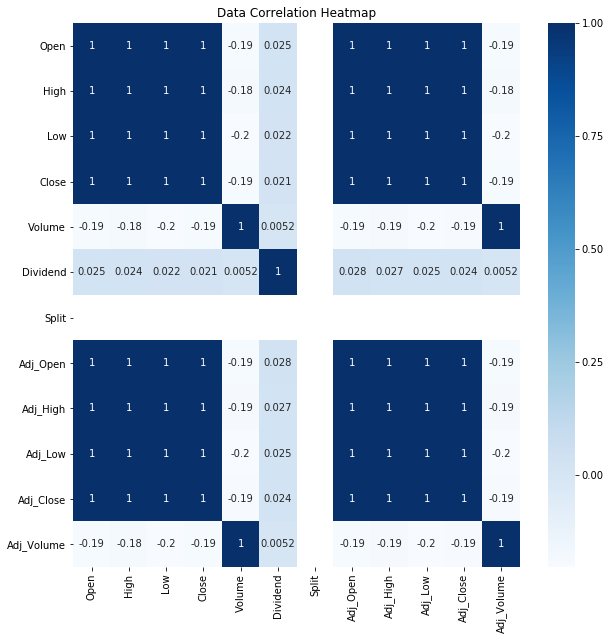

In [95]:
quandl_key = get_key('quandl_key')
#intrinio_key = get_key('intrinio_key')
quandl.ApiConfig.api_key = quandl_key
#apple = intrinio_get(intrinio_key)
boeing = quandl_get()
display(boeing.head())
plot_corr(boeing,size=10)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


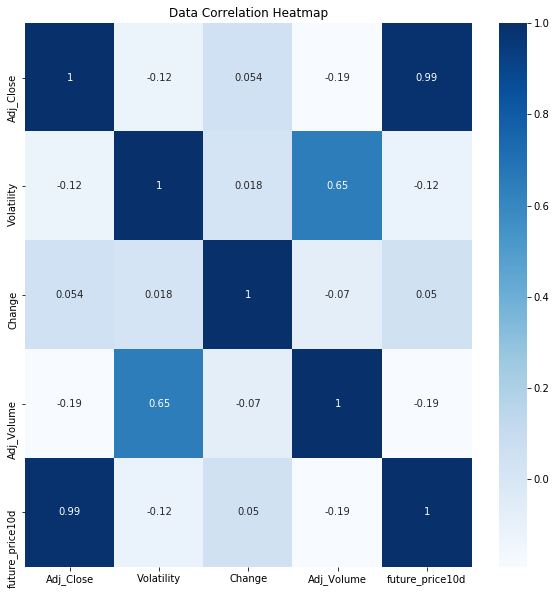

In [96]:
data = feature_eng(boeing)
plot_corr(data,size=10)

In [20]:
X = data_ready.drop('future_price10d', axis=1)
X = preprocessing.scale(X)
y = data_ready['future_price10d']

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)
reg = LinearRegression(n_jobs=-1)
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.9836279705940811